In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [2]:
data = pd.read_csv("Cleaned_TF_BIRTHS.csv")

In [3]:
print("Dataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11688 entries, 0 to 11687
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    11688 non-null  object
 1   Births  11688 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 182.8+ KB
None

Summary Statistics:
             Births
count  11688.000000
mean     326.308607
std       79.805968
min      148.000000
25%      236.000000
50%      356.000000
75%      387.000000
max      493.000000


In [4]:
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Date      0
Births    0
dtype: int64


In [5]:
print("\nFirst 5 Rows of the Dataset:")
print(data.head())
print("\nlast 5 Rows of the Dataset:")
print(data.tail())


First 5 Rows of the Dataset:
         Date  Births
0  1992-01-01     219
1  1992-01-02     331
2  1992-01-03     420
3  1992-01-04     282
4  1992-01-05     252

last 5 Rows of the Dataset:
             Date  Births
11683  2023-12-27     329
11684  2023-12-28     318
11685  2023-12-29     312
11686  2023-12-30     191
11687  2023-12-31     171


In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data.rename(columns={'Date': 'ds', 'Births': 'y'}, inplace=True)

data['y'] = data['y'].fillna(data['y'].median())

#for outliers
data['zscore'] = zscore(data['y'])
data = data[(data['zscore'] > -3) & (data['zscore'] < 3)].drop(columns=['zscore'])

In [7]:
data['DayOfWeek'] = data['ds'].dt.dayofweek
data['WeekOfYear'] = data['ds'].dt.isocalendar().week
data['Month'] = data['ds'].dt.month
data['Year'] = data['ds'].dt.year

scaler = MinMaxScaler()
data['y_scaled'] = scaler.fit_transform(data[['y']])
print("\nPreprocessed Data Sample:")
print(data.head())


Preprocessed Data Sample:
          ds    y  DayOfWeek  WeekOfYear  Month  Year  y_scaled
0 1992-01-01  219          2           1      1  1992  0.205797
1 1992-01-02  331          3           1      1  1992  0.530435
2 1992-01-03  420          4           1      1  1992  0.788406
3 1992-01-04  282          5           1      1  1992  0.388406
4 1992-01-05  252          6           1      1  1992  0.301449


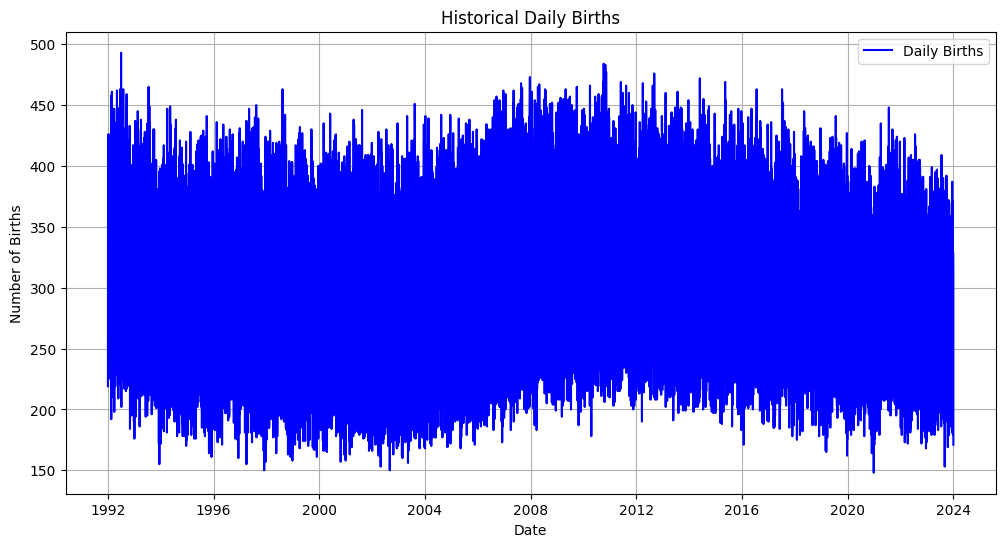

In [8]:
#historical data
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], label="Daily Births", color='blue')
plt.title('Historical Daily Births')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.grid()
plt.show()

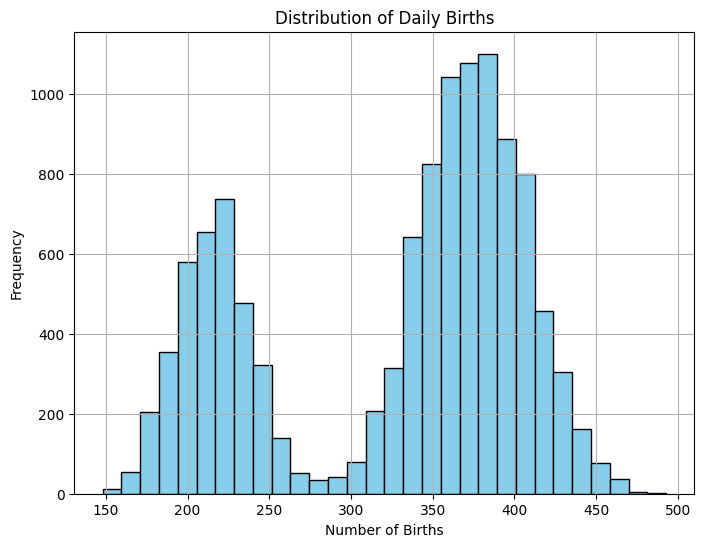

In [10]:
#births Distribution
plt.figure(figsize=(8, 6))
plt.hist(data['y'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Births')
plt.xlabel('Number of Births')
plt.ylabel('Frequency')
plt.grid()
plt.show()

<Figure size 1000x600 with 0 Axes>

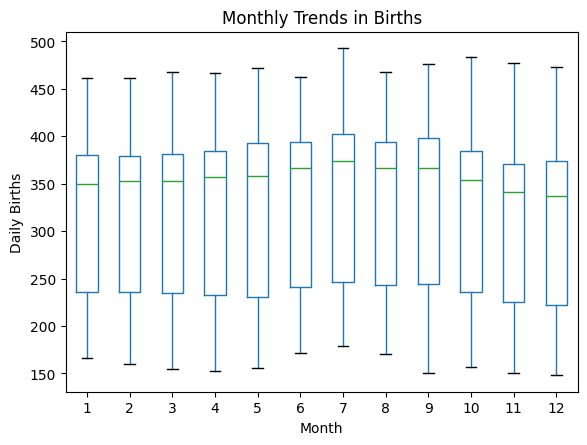

In [11]:
# Boxplot
plt.figure(figsize=(10, 6))
data.boxplot(column='y', by='Month')
plt.title('Monthly Trends in Births')
plt.suptitle("")  # Remove default title
plt.xlabel('Month')
plt.ylabel('Daily Births')
plt.grid()
plt.show()

In [12]:
model = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(data[['ds', 'y']])

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

print("\nForecasted Data Sample:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

00:18:48 - cmdstanpy - INFO - Chain [1] start processing
00:19:01 - cmdstanpy - INFO - Chain [1] done processing



Forecasted Data Sample:
              ds        yhat  yhat_lower  yhat_upper
12048 2024-12-26  328.209672  290.996740  370.419618
12049 2024-12-27  331.308118  291.840134  373.574317
12050 2024-12-28  175.117056  134.649803  217.505445
12051 2024-12-29  168.810587  129.240265  208.879843
12052 2024-12-30  314.641019  272.083853  354.028151


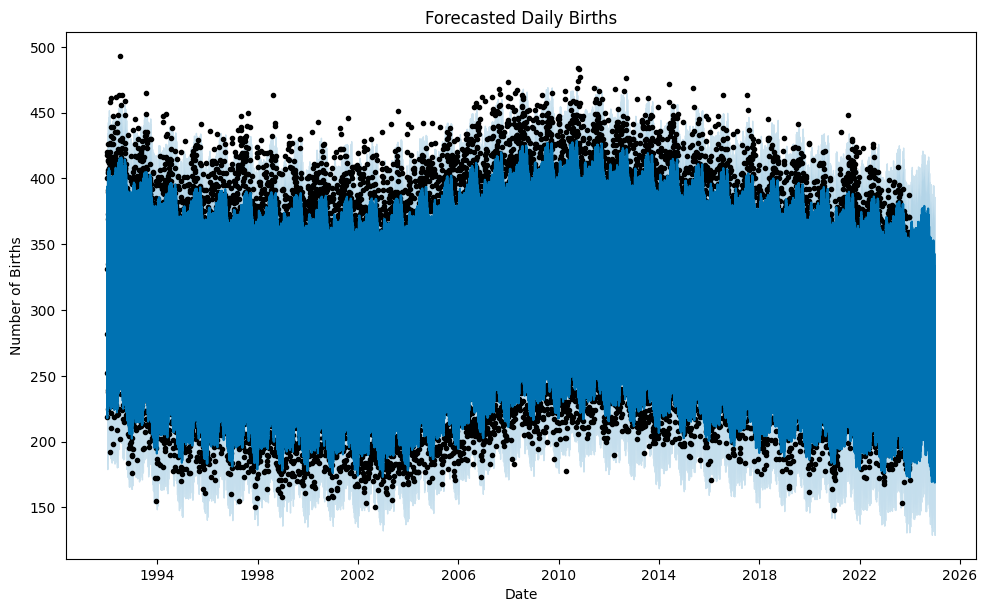

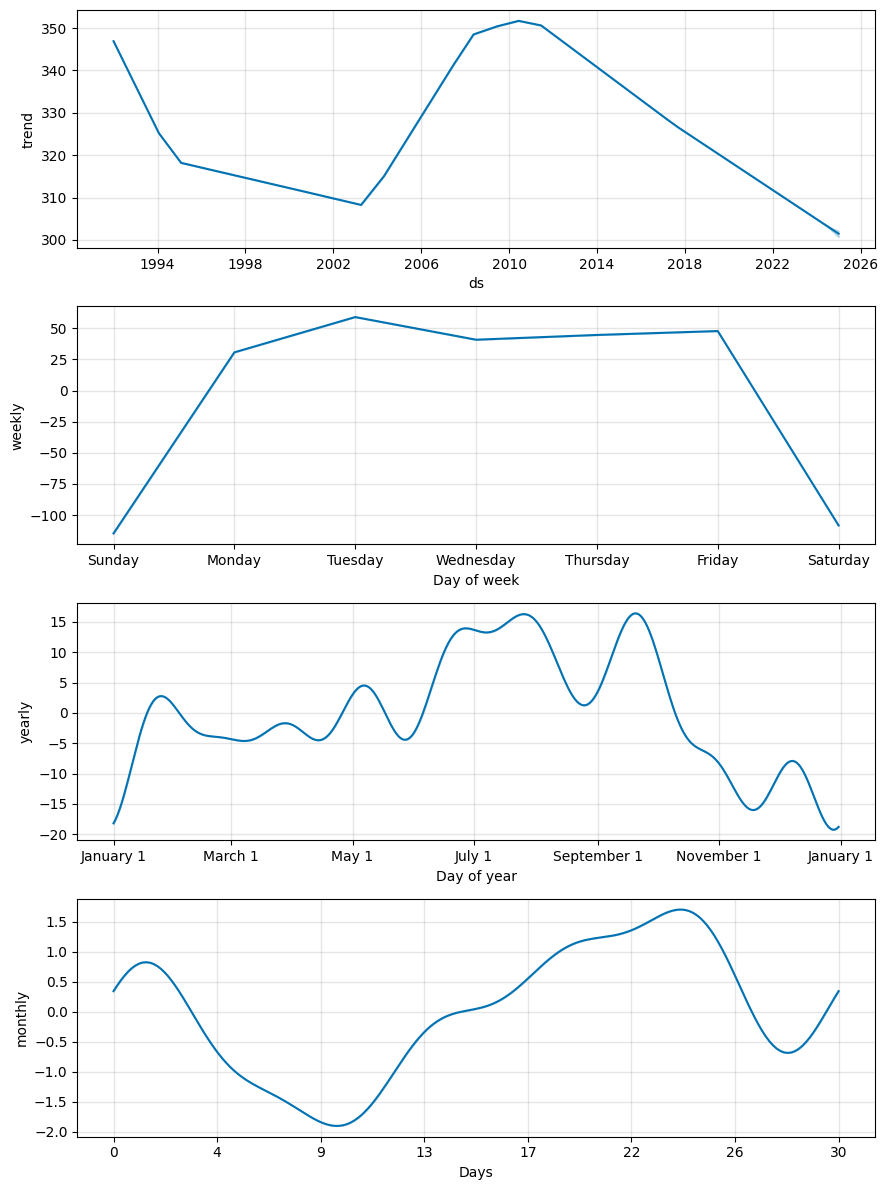

In [13]:
model.plot(forecast)
plt.title('Forecasted Daily Births')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.grid()
plt.show()
model.plot_components(forecast)
plt.show()

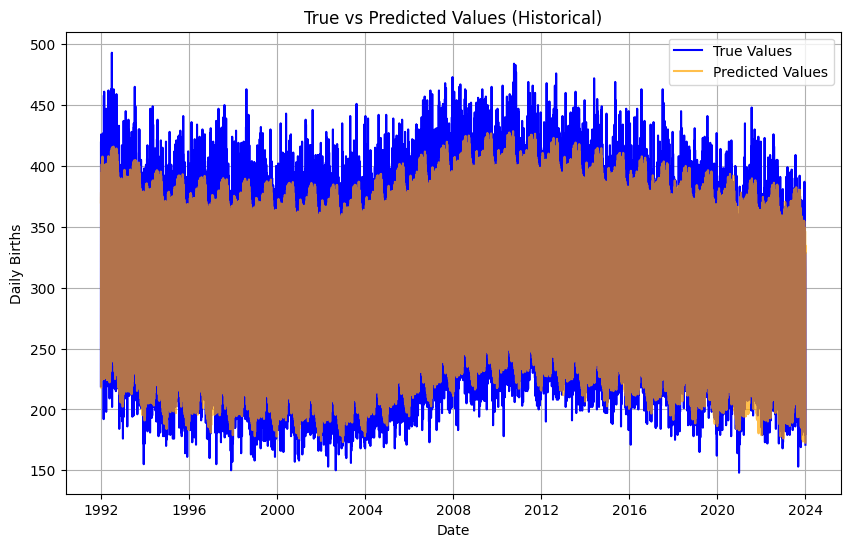

In [14]:
historical = forecast[forecast['ds'] <= data['ds'].max()]
true_values = data['y'].values
predicted_values = historical['yhat'].values

#true vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(data['ds'], true_values, label="True Values", color='blue')
plt.plot(data['ds'], predicted_values, label="Predicted Values", color='orange', alpha=0.7)
plt.title('True vs Predicted Values (Historical)')
plt.xlabel('Date')
plt.ylabel('Daily Births')
plt.legend()
plt.grid()
plt.show()

In [15]:
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
r2 = r2_score(true_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 21.61508415757094
Root Mean Squared Error (RMSE): 32.00479250012585
Mean Absolute Percentage Error (MAPE): 7.19%
R-squared (R2): 0.8391591164580692


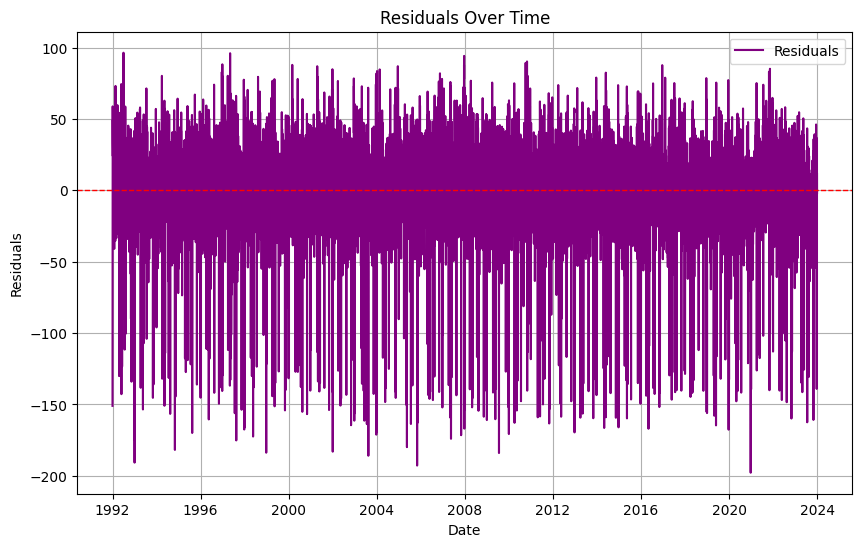

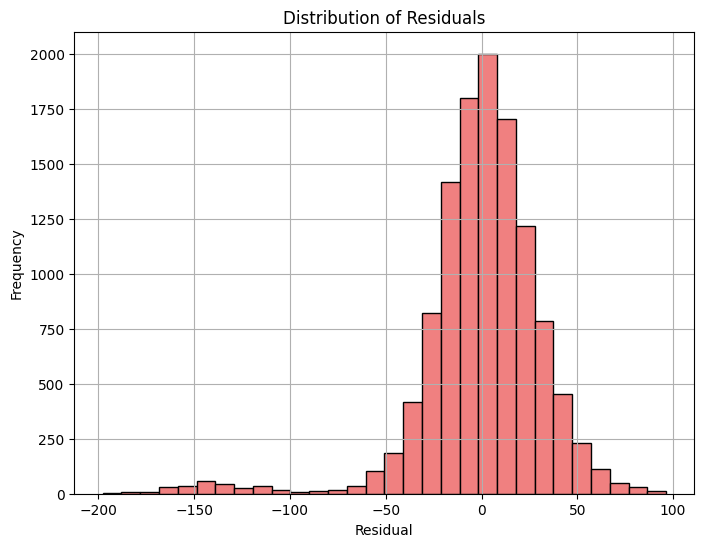

In [16]:
#residuals
residuals = true_values - predicted_values

plt.figure(figsize=(10, 6))
plt.plot(data['ds'], residuals, label="Residuals", color='purple')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [17]:
accuracy = 100 - mape
print(f"Model Accuracy: {accuracy:.2f}%")

bias = np.mean(residuals)
print(f"Model Bias: {bias:.2f}")

Model Accuracy: 92.81%
Model Bias: 0.00


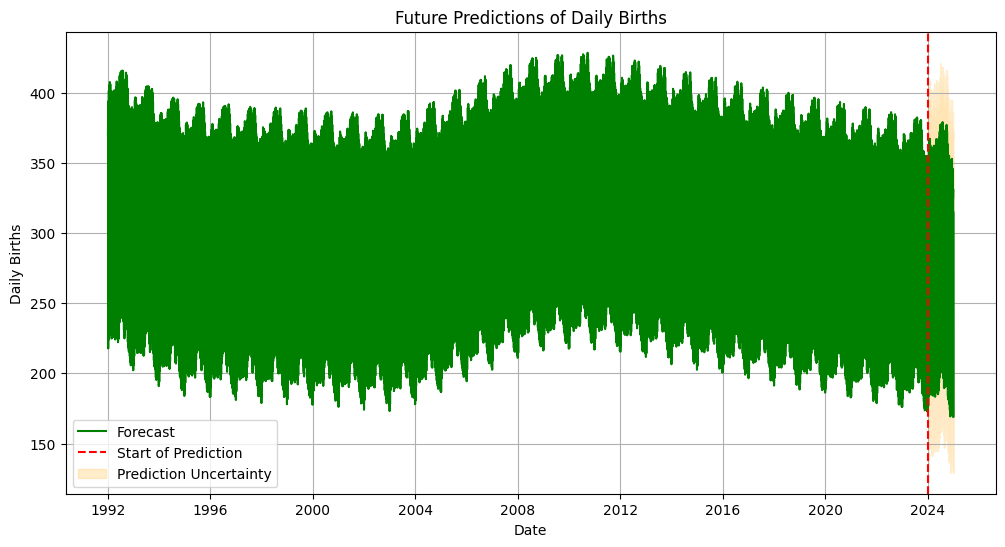

In [19]:
future_predictions = forecast[forecast['ds'] > data['ds'].max()]

plt.figure(figsize=(12, 6))
plt.plot(forecast['ds'], forecast['yhat'], label="Forecast", color='green')
plt.axvline(x=data['ds'].max(), color='red', linestyle='--', label="Start of Prediction")
plt.fill_between(future_predictions['ds'], 
                 future_predictions['yhat_lower'], 
                 future_predictions['yhat_upper'], color='orange', alpha=0.2, label="Prediction Uncertainty")
plt.title('Future Predictions of Daily Births')
plt.xlabel('Date')
plt.ylabel('Daily Births')
plt.legend()
plt.grid()
plt.show()